In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from tqdm.auto import tqdm
import seaborn as sns

from src.colorconv import ConvexCluster
from src.util import (non_dominated_front,
                      compression,
                      informativeness,
                      degree_of_convexity)


sns.set(context='paper', style='ticks', font='DejaVu Sans', font_scale=1)

In [2]:
# unpockle IB_color_naming.pkl from data
with open('data/IB_color_naming.pkl', 'rb') as f:
    IB_color_naming = pickle.load(f)

# unpickle chip dict
with open('data/chip_dict.pkl', 'rb') as f:
    chip_dict = pickle.load(f)

# unpickle sielab_dict
with open('data/cielab_dict.pkl', 'rb') as f:
    cielab_dict = pickle.load(f)   

In [3]:
prior_m = IB_color_naming['pM']

# match index of prior_m to chip_dict coordinates 
# and build a new dict (coordinate: probability)
prior_m_ = []
for i, p in enumerate(prior_m):
    prior_m_.append((chip_dict[i+1], p))

# remove entries with first coordinate == 1
prior_m_ = [x for x in prior_m_ if x[0][1] != 0]

# use coordinate from prior_m_ to build a matrix with probabilities
prior_m_matrix = np.zeros((8, 40))
for c, p in prior_m_:
    prior_m_matrix[c[0]-1, c[1]-1] = p

In [4]:
# only choose coordinates in the range (0, 0), (8, 40)
cielab_dict_ = {k: v for k, v in cielab_dict.items() if k[0] in range(0, 9) and k[1] in range(0, 41)}

# reverse keys and values in cielab_dict_
cielab_dict_r = {v: k for k, v in cielab_dict_.items()}

# convert cielab_dict_ to a list of tuples ordered from (0, 0) to (8, 40)
cielab_list = [cielab_dict_[k] for k in sorted(cielab_dict_.keys())]

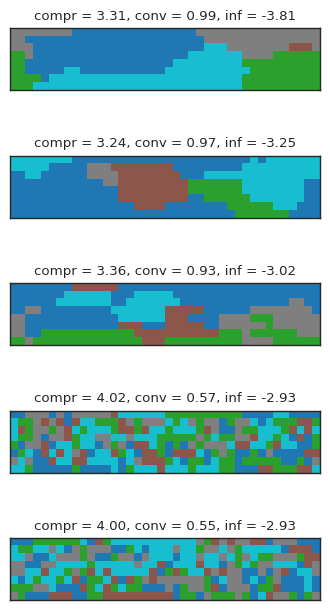

In [5]:
# just change convexity in the range 0.05 - 1
conn_values = [0.0005, 0.001, 0.01, 0.1, 1]

fig, ax = plt.subplots(5, 1, figsize=(4, 8))

for j, conn in enumerate(conn_values):
    a = ConvexCluster(X = np.zeros((8, 40)), 
                        d = 8, 
                        N = 5, 
                        s = 0.5, 
                        c = conn,
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
    labels = a.run()
    ax[j].imshow(labels, cmap='tab10', interpolation='none')
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].set_title(f'compr = {compression(labels):.2f}, '
                    f'conv = {a.degree_of_convexity():.2f}, ' 
                    f'inf = {informativeness(labels, prior_m_matrix, cielab_dict):.2f}')

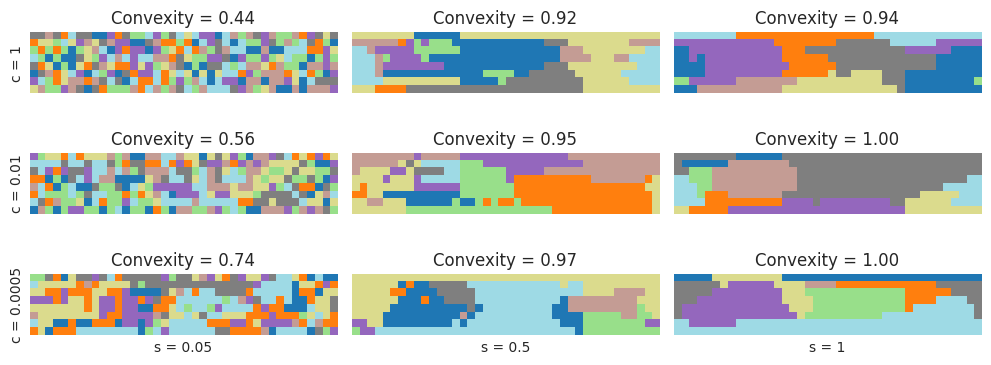

In [6]:
# plot 4 x 4 possible color clusters with parameter smooth in [0.1, 0.25, 0.5, 1] and conn in [0.1, 0.25, 0.5, 1]
fig, ax = plt.subplots(3, 3, figsize=(10, 4))

smooth_values = [0.05, 0.5, 1]
conn_values = [0.0005, 0.01, 1]
conn_values = [_ for _ in reversed(conn_values)]

for i, smooth in enumerate(smooth_values):
    for j, conn in enumerate(conn_values):
        a = ConvexCluster(X = np.zeros((8, 40)), 
                         d = 2, 
                         N = 8, 
                         s = smooth, 
                         c = conn,
                         coords=cielab_list,
                         reverse_labels=cielab_dict_r)
        labels = a.run()
        ax[i, j].imshow(labels, 
                        cmap='tab20', 
                        interpolation='none')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'Convexity = {a.degree_of_convexity():.2f}', fontsize=12)
        # remove border
        for spine in ax[i, j].spines.values():
            spine.set_visible(False)
        # ax[i, j].set_title(f'MDL = {mdl(labels):.2f}')
        
# Label the conn values on the y-axis
for i, conn in enumerate(conn_values):
    ax[i, 0].set_ylabel('c = ' + str(conn), fontsize=10)

# Label the smooth values on the x-axis
for j, smooth in enumerate(smooth_values):
    ax[2, j].set_xlabel('s = ' + str(smooth), fontsize=10)

plt.tight_layout()
# save the plot as pdf
plt.savefig('figures/convex_clusters.pdf')
plt.show()

In [7]:
def generate_grid(n, n_low, n_high, d = 2, X = 10, Y = 10):
    s_values = np.random.uniform(0.8, 1, n)
    c_values = np.random.uniform(0, 0.1, n)

    mdl_values = []
    conv_values = []
    cost_values = []
    categ = []
    param_dict = {}
    lgs = []

    for i, sc in tqdm(enumerate(zip(s_values, c_values)), total=n, desc='Generating Grid'):
        N = np.round(np.random.uniform(n_low, n_high), 0).astype(int)
        a = ConvexCluster(X = np.zeros((X, Y)), 
                        d = d, 
                        N = N,
                        s = sc[0], 
                        c = sc[1],
                        coords=cielab_list,
                        reverse_labels=cielab_dict_r)
        l = a.run()
        
        lgs.append(l)
        param_dict[i] = (sc[0], sc[1], N)
        mdl_values.append(compression(l))
        conv_values.append(a.degree_of_convexity())
        cost_values.append(informativeness(l, 
                                           prior_m_matrix, 
                                           cielab_dict))
        categ.append(N)
    
    return mdl_values, conv_values, cost_values, categ, param_dict, lgs

In [8]:
# results = generate_grid(n = 30000, 
#                         d = 2, 
#                         X = 8,
#                         Y = 40,
#                         n_low = 3,
#                         n_high = 15)

In [9]:
# dump results to pickle
# with open('data/convex_cluster_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

# import results from pickle
with open('data/convex_cluster_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [10]:
mdl_values, conv_values, cost_values, categ, param_dict, lgs = results

In [11]:
# recompute mdl_values
mdl_values = [compression(l) for l in lgs]

In [12]:
# iterate over cost_values, if a value is inf, then remove it from the list and from the other lists
for i, val in enumerate(cost_values):
    if np.isinf(val):
        mdl_values.pop(i)
        conv_values.pop(i)
        categ.pop(i)
        cost_values.pop(i)

In [13]:
pareto_front_indices = non_dominated_front(mdl_values, cost_values)
pareto_front_points = [(mdl_values[i], cost_values[i]) for i in pareto_front_indices]

# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))

x_pareto, y_pareto = zip(*pareto_front_points)

In [14]:
# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto)

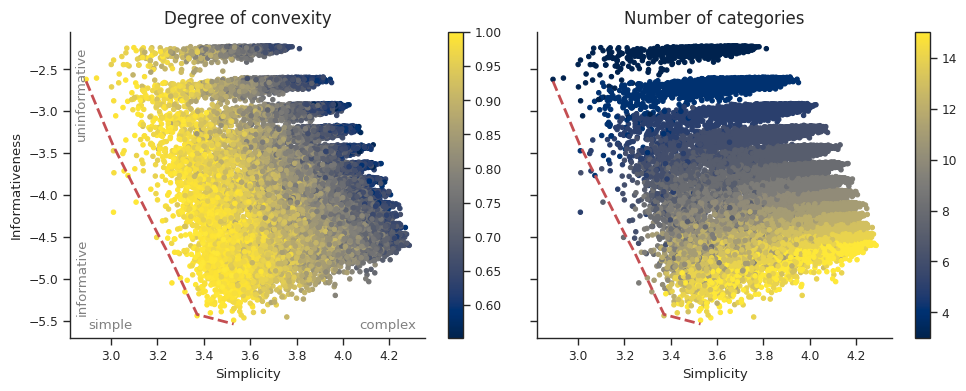

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)
sns.despine(top=True, right=True)

# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=1,  linewidth=2)
# ax1.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
scatter1.set_rasterized(True)
ax1.text(-1.28, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.28, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.2, 0.04, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.42, 0.04, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity', fontsize=12)
cbar1 = fig.colorbar(scatter1, ax=ax1)

# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax2.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=1, linewidth=2)
# ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
scatter2.set_rasterized(True)
# ax2.set_xlabel('simple <------------------------> complex')
# add text in the top and bottom left corner
# ax2.text(0.05, 0.2, 'informative', ha='center',
#          va='center', transform=ax2.transAxes,
#          color = 'grey', rotation = 90)
# ax2.text(0.05, 0.8, 'uninformative', ha='center',
#          va='center', transform=ax2.transAxes,
#          color = 'grey', rotation = 90)
# ax2.text(0.12, 0.05, 'simple', ha='center', 
#          va='center', transform=ax2.transAxes,
#          color = 'grey')
# ax2.text(0.9, 0.05, 'complex', ha='center', 
#          va='center', transform=ax2.transAxes,
#          color = 'grey')
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories', fontsize=12)
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2)

plt.tight_layout()

# save the plot as pdf
plt.savefig('figures/convexity_categories.pdf')
plt.show()

In [41]:
# for each point in (mdl_values, cost_values), calculate the distance to the points in the pareto front
distances = []

x_pareto = np.array(x_pareto)
y_pareto = np.array(y_pareto)

for i, j in zip(mdl_values, cost_values):
    distances.append(np.min(np.sqrt((i - x_pareto)**2 + (j - y_pareto)**2)))

In [42]:
df = pd.DataFrame({'convexity': conv_values,
                   'categories': categ,
                   'distance': distances,
                   'simplicity': mdl_values})

In [43]:
# standardize categories and convexity
df['categories_z'] = (df['categories'] - df['categories'].mean()) / df['categories'].std()
df['convexity_z'] = (df['convexity'] - df['convexity'].mean()) / df['convexity'].std()
df['simplicity_z'] = (df['simplicity'] - df['simplicity'].mean()) / df['simplicity'].std()

In [44]:
# statsmodels regression predicting distance from convexity and number of categories

# remove nan or inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df[['convexity_z',  'simplicity_z']] # 'categories_z',
y = df['distance']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# summarize our model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 9.450e+04
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:29:08   Log-Likelihood:                 34608.
No. Observations:               30000   AIC:                        -6.921e+04
Df Residuals:                   29997   BIC:                        -6.918e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8003      0.000   1815.647      0.000       0.799       0.801
convexity_z     -0.1198      0.001   -197.981      0.000      -0.121      -0.119
simplicity_z     0.0885      0.001    146.252      0.000       0.087       0.090
==============================================================================
Omnibus:                       23.726   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.947
Skew:                           0.047   Prob(JB):                     3.83e-06
Kurtosis:                       3.106   Cond. No.                         2.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# do a similar model but with number of categories and simplicity
X = df[['categories_z', 'simplicity_z']]
y = df['distance']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# summarize our model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 2.307e+05
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:29:08   Log-Likelihood:                 46734.
No. Observations:               30000   AIC:                        -9.346e+04
Df Residuals:                   29997   BIC:                        -9.344e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8003      0.000   2720.009      0.000       0.800       0.801
categories_z    -0.1208      0.000   -353.968      0.000      -0.121      -0.120
simplicity_z     0.2317      0.000    679.224      0.000       0.231       0.232
==============================================================================
Omnibus:                      742.112   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1092.069
Skew:                           0.268   Prob(JB):                    7.25e-238
Kurtosis:                       3.766   Cond. No.                         1.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

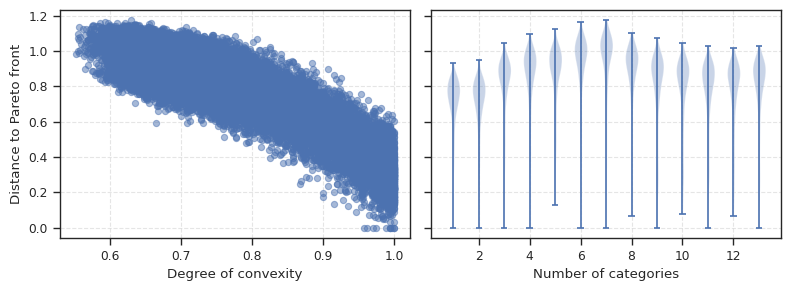

In [46]:
# Create a scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot convexity vs distance
ax1.set_axisbelow(True)
ax1.grid(linestyle='--', alpha=0.5)
s = ax1.scatter(df['convexity'], df['distance'], alpha=0.5, s=20)
s.set_rasterized(True)
ax1.set_xlabel('Degree of convexity')
ax1.set_ylabel('Distance to Pareto front')

# Plot categories vs distance
# ax2.scatter(df['categories'], df['distance'], alpha=0.5, s=20)
ax2.set_axisbelow(True)
ax2.grid(linestyle='--', alpha=0.5)
ax2.violinplot(df.groupby('categories')['distance'].apply(list).to_list(), vert=True)
ax2.set_xlabel('Number of categories')

plt.tight_layout()
# save to pdf
plt.savefig('figures/convexity_categories_distance.pdf', dpi=300)
plt.show()

In [47]:
with open('data/lg_color.pkl', 'rb') as f:
    lg_color = pickle.load(f)

In [48]:
len(lg_color)

110

In [49]:
# enumerate over grids in lg_color and calculate informativeness
informativeness_values = []
simplicity_values = []
categ_values = []

for grid in lg_color:
    informativeness_values.append(informativeness(lg_color[grid], prior_m_matrix, cielab_dict))
    simplicity_values.append(compression(lg_color[grid]))
    categ_values.append(len(np.unique(lg_color[grid])))

In [50]:
# count the number of unique values in each grid in lg_color
unique_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# print min and max
print(min(unique_values), max(unique_values))

3 15


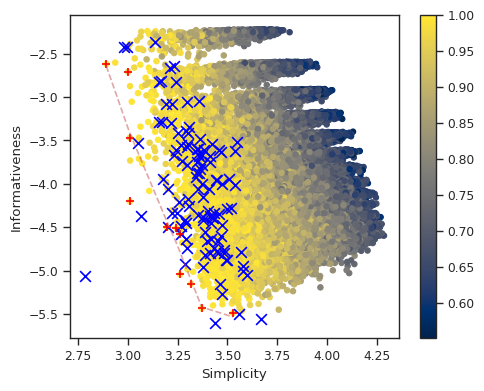

In [51]:
plt.figure(figsize=(5, 4))
scatter = plt.scatter(mdl_values, cost_values, c=conv_values, cmap='cividis', alpha=1, s = 15, marker = 'o')
scatter.set_rasterized(True)
plt.colorbar(alpha=1)
plt.scatter(simplicity_values, informativeness_values, c='blue', marker='x', s=60)
plt.scatter(*zip(*pareto_front_points),
            c='red', 
            marker='+',
            s=30)
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
plt.ylabel('Informativeness')
plt.xlabel('Simplicity')
plt.tight_layout()
plt.savefig('figures/convexity_WCS.pdf', dpi=300)
plt.show()

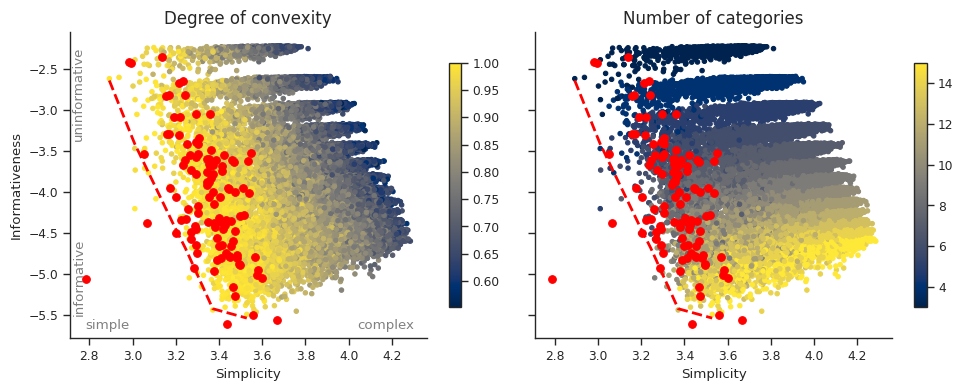

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
                               sharey=True)
sns.despine(top=True, right=True)
# Plot with convexity
scatter1 = ax1.scatter(mdl_values, cost_values, 
                       c=conv_values, cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax1.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1,  
         linewidth=2, linestyle='--')
ax1.scatter(simplicity_values, informativeness_values, 
            c='red', marker='o', s=30)
scatter1.set_rasterized(True)
ax1.text(-1.28, 0.2, 'informative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.28, 0.8, 'uninformative', ha='center',
         va='center', transform=ax2.transAxes,
         color = 'grey', rotation = 90)
ax1.text(-1.2, 0.04, 'simple', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.text(-0.42, 0.04, 'complex', ha='center', 
         va='center', transform=ax2.transAxes,
         color = 'grey')
ax1.set_xlabel('Simplicity')
ax1.set_ylabel('Informativeness')
ax1.set_title('Degree of convexity', fontsize=12)
cbar1 = fig.colorbar(scatter1, ax=ax1, shrink=0.8)
# Plot with number of categories
scatter2 = ax2.scatter(mdl_values, cost_values, c=categ, 
                       cmap='cividis', alpha=1,
                       s = 10, marker = 'o')
ax2.plot(smoothed[:, 0], smoothed[:, 1], 
         color = 'red', alpha=1, 
         linewidth=2, linestyle='--')
ax2.scatter(simplicity_values, informativeness_values, c='red', marker='o', s=30)
# ax2.scatter(*zip(*pareto_front_points), c='red', marker='x', s=20)
scatter2.set_rasterized(True)
ax2.set_xlabel('Simplicity')
ax2.set_title('Number of categories', fontsize=12)
# ax2.grid(linestyle='--', alpha=0.5)
cbar2 = fig.colorbar(scatter2, ax=ax2, shrink=0.8)

plt.tight_layout()

# save the plot as pdf
plt.savefig('figures/convexity_categories.pdf')
plt.show()

In [28]:
# measure the degree of convexity for each grid in lg_color
convexity_values = [degree_of_convexity(np.expand_dims(lg_color[grid], axis=0))[0] for grid in lg_color]
# compute the number of categories for each grid in lg_color
categories_values = [len(np.unique(lg_color[grid])) for grid in lg_color]
# compute the distance to the pareto front for each grid in lg_color
distances_values = [np.min(np.sqrt((simplicity_values[i] - x_pareto)**2 + 
                                   (informativeness_values[i] - y_pareto)**2)) for i in range(len(simplicity_values))]

# standardize the values
simplicity_values_z = (simplicity_values - np.mean(simplicity_values)) / np.std(simplicity_values)
informativeness_values_z = (informativeness_values - np.mean(informativeness_values)) / np.std(informativeness_values)
convexity_values_z = (convexity_values - np.mean(convexity_values)) / np.std(convexity_values)
categ_values_z = (categories_values - np.mean(categories_values)) / np.std(categories_values)

# create a dataframe
df_lg = pd.DataFrame({'convexity': convexity_values,
                      'categories': categories_values,
                      'convexity_z': convexity_values_z,
                      'categories_z': categ_values_z,
                      'distance': distances_values})

(0.0, 1.0)

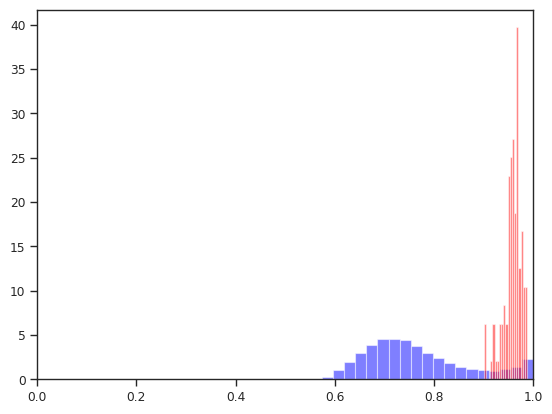

In [29]:
plt.hist(conv_values, bins=20, color='blue', alpha=0.5, label='WCS', density=True)
plt.hist(convexity_values, bins=20, color='red', alpha=0.5, label='LG', density=True)
plt.xlim(0, 1)

In [30]:
# run a linear regression
X = df_lg[['categories_z', 'convexity_z']]
y = df_lg['distance']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.123
Date:                Mon, 18 Mar 2024   Prob (F-statistic):              0.125
Time:                        17:28:50   Log-Likelihood:                 70.057
No. Observations:                 110   AIC:                            -134.1
Df Residuals:                     107   BIC:                            -126.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2957      0.012     23.900      0.000       0.271       0.320
categories_z    -0.0252      0.017     -1.485      0.140      -0.059       0.008
convexity_z      0.0004      0.017      0.025      0.980      -0.033       0.034
==============================================================================
Omnibus:                        2.102   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                1.508
Skew:                          -0.027   Prob(JB):                        0.471
Kurtosis:                       2.429   Cond. No.                         2.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# summary to latex
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     distance     & \textbf{  R-squared:         } &     0.038   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.020   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     2.123   \\
\textbf{Date:}             & Mon, 18 Mar 2024 & \textbf{  Prob (F-statistic):} &    0.125    \\
\textbf{Time:}             &     17:28:50     & \textbf{  Log-Likelihood:    } &    70.057   \\
\textbf{No. Observations:} &         110      & \textbf{  AIC:               } &    -134.1   \\
\textbf{Df Residuals:}     &         107      & \textbf{  BIC:               } &    -126.0   \\
\textbf{Df Model:}         &           2      & \textbf{                     } &             \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                       & \textbf{coef} 

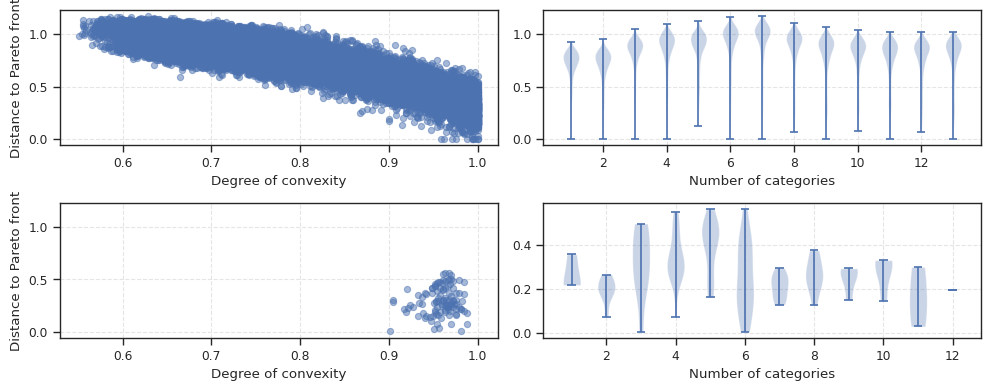

In [32]:
# Create a scatter plot with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))

# Plot convexity vs distance (subplot 1)
ax1.set_axisbelow(True)
ax1.grid(linestyle='--', alpha=0.5)
s1 = ax1.scatter(df['convexity'], df['distance'], alpha=0.5, s=20)
s1.set_rasterized(True)
ax1.set_xlabel('Degree of convexity')
ax1.set_ylabel('Distance to Pareto front')

# Plot categories vs distance (subplot 2)
ax2.set_axisbelow(True)
ax2.grid(linestyle='--', alpha=0.5)
ax2.violinplot(df.groupby('categories')['distance'].apply(list).to_list(), vert=True)
ax2.set_xlabel('Number of categories')

# Plot convexity vs distance (subplot 3)
ax3.set_axisbelow(True)
ax3.grid(linestyle='--', alpha=0.5)
s2 = ax3.scatter(df_lg['convexity'], df_lg['distance'], alpha=0.5, s=20)
s2.set_rasterized(True)
ax3.set_xlabel('Degree of convexity')
ax3.set_ylabel('Distance to Pareto front')
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())

# Plot categories vs distance (subplot 4)
ax4.set_axisbelow(True)
ax4.grid(linestyle='--', alpha=0.5)
ax4.violinplot(df_lg.groupby('categories')['distance'].apply(list).to_list(), vert=True)
ax4.set_xlabel('Number of categories')

plt.tight_layout()
# save to pdf
plt.savefig('figures/combined_plot.pdf', dpi=300)
plt.show()

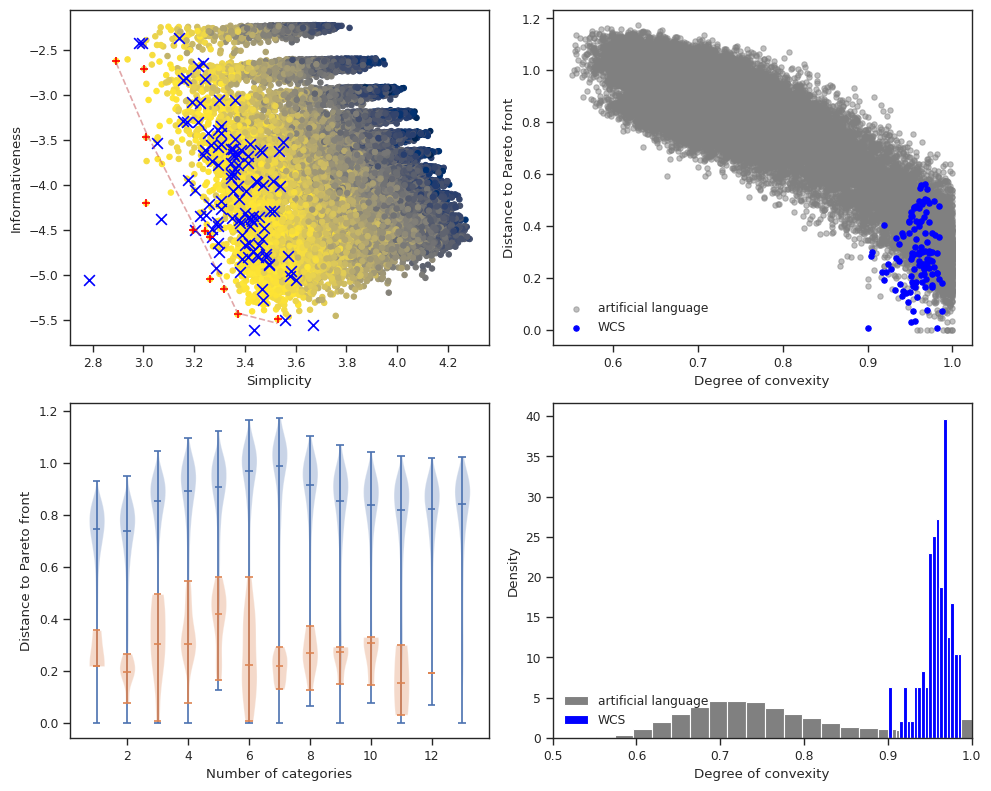

In [33]:
# Create a scatter plot with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Plot convexity vs distance (subplot 3)
ax1.set_axisbelow(True)
s3 = ax1.scatter(mdl_values, cost_values, c=conv_values, cmap='cividis', alpha=1, s=15, marker='o')
s3.set_rasterized(True)
ax1.scatter(simplicity_values, informativeness_values, c='blue', marker='x', s=60)
ax1.scatter(*zip(*pareto_front_points), c='red', marker='+', s=30)
ax1.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
ax1.set_ylabel('Informativeness')
ax1.set_xlabel('Simplicity')
# cbar1 = fig.colorbar(s3, ax=ax1)

# Add the new code as the first subplot
ax2.set_axisbelow(True)
# ax2.grid(linestyle='--', alpha=0.5)
s1 = ax2.scatter(df['convexity'], df['distance'], alpha=0.5, s=15, color='grey', label='artificial language')
s1.set_rasterized(True)
s2 = ax2.scatter(df_lg['convexity'], df_lg['distance'], alpha=1, s=15, color='blue', label='WCS')
s2.set_rasterized(True)
ax2.set_xlabel('Degree of convexity')
ax2.set_ylabel('Distance to Pareto front')
ax2.legend(frameon=False, loc='lower left')

# Plot convexity vs distance (subplot 2)
ax3.set_axisbelow(True)
# ax3.grid(linestyle='--', alpha=0.5)
ax3.violinplot(df.groupby('categories')['distance'].apply(list).to_list(), vert=True, showmeans=False, showmedians=True)
ax3.violinplot(df_lg.groupby('categories')['distance'].apply(list).to_list(), vert=True, showmeans=False, showmedians=True)
ax3.set_xlabel('Number of categories')
ax3.set_ylabel('Distance to Pareto front')

# Add the new code as the fourth subplot
ax4.hist(conv_values, bins=20, color='grey', 
         alpha=1, label='artificial language', density=True)
ax4.hist(convexity_values, bins=20, color='blue', 
         alpha=1, label='WCS', density=True)
ax4.legend(frameon=False, loc='lower left')
ax4.set_xlabel('Degree of convexity')
ax4.set_ylabel('Density')
ax4.set_xlim(0.5, 1)

plt.tight_layout()
# save to pdf
plt.savefig('figures/convexity_WCS.pdf', dpi=300)
plt.show()

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_4640/2864051231.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(categ, cost_values, c='grey', cmap='cividis', alpha=0.1,


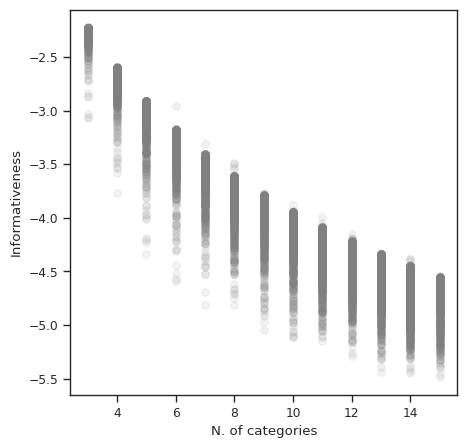

In [34]:
plt.figure(figsize=(5, 5))
plt.scatter(categ, cost_values, c='grey', cmap='cividis', alpha=0.1,
                       s = 30, marker = 'o')
# plt.colorbar(alpha=1)
# plt.scatter(*zip(*pareto_front_points),
#             c='red', 
#             marker='x',
#             s=20)
# plt.plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=0.5)
# plt.scatter(categ_values, informativeness_values, c='red', marker='+', s=30)
# plt.gca().invert_yaxis()
plt.ylabel('Informativeness')
plt.xlabel('N. of categories')
# plt.yscale('log')
plt.show()

In [35]:
def plot_n_neighbours(idx_list, n):
    k = len(idx_list)  # Number of indices in the list
    fig, ax = plt.subplots(n, k, figsize=(8, 3))  # Adjust figsize as needed

    for col, idx in enumerate(idx_list):
        distances = []
        comp = compression(lg_color[idx])
        info = informativeness(lg_color[idx], prior_m_matrix, cielab_dict)

        for i, j in zip(mdl_values, cost_values):
            distances.append(np.sqrt((i - comp)**2 + (j - info)**2))

        # Sort distances (from smallest to largest) and get the indices
        nearest_indices = np.argsort(distances)[:n]

        for row, nearest_idx in enumerate(nearest_indices):
            if row == 0:
                ax[row, col].set_title(f'Language {idx}')
                ax[row, col].imshow(lg_color[idx], cmap='tab10', interpolation='none')
            else:
                ax[row, col].set_title(f'{row}-st nearest')
                ax[row, col].imshow(lgs[nearest_idx], cmap='tab10', interpolation='none')
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            # remove border
            for spine in ax[row, col].spines.values():
                spine.set_visible(False)

    # plt.tight_layout()
    plt.savefig('figures/nearest_neighbours.pdf', dpi=600)
    plt.show()


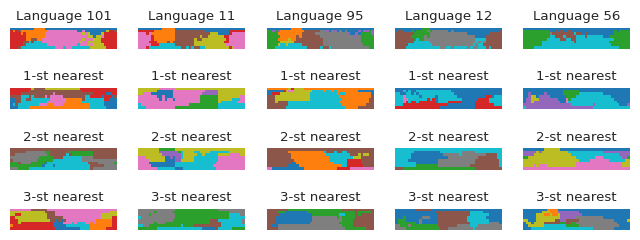

In [36]:
# Sample 3 random indexes
# random_indexes = np.random.choice(len(lg_color), 3, replace=False)
random_indexes = [101,  11,  95, 12, 56]

# Plot nearest neighbors
plot_n_neighbours(random_indexes, 4)

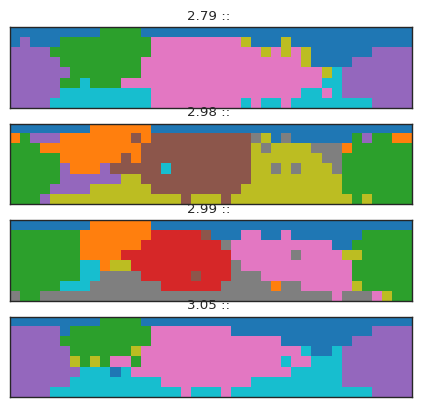

In [37]:
# plot the language with the lowest complexity from real languages
# mdl_index = np.argmin(simplicity_values)
# index the first two smallest values from simplicity_values
mdl_index = np.argsort(simplicity_values)[:4]
# plot the labgugge with the lowest mdl
fig, ax = plt.subplots(4, 1)
for i in range(4):
    # print(mdl_index[i])
    # print(simplicity_values[mdl_index[i]])
    ax[i].set_title(f'{simplicity_values[mdl_index[i]]:.2f} :: ')
    ax[i].imshow(lg_color[mdl_index[i]], cmap='tab10', interpolation='none')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

In [38]:
degree_of_convexity(np.expand_dims(lg_color[mdl_index[0]], axis=0))

array([0.96718232])

In [39]:
lg_color[mdl_index[0]]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 3, 4, 3, 4, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 1, 1, 5, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 5, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 